In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import sys
# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [3]:
import os
import torch 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from arabert import ArabertPreprocessor

# Import PyTorch-based functions and classes from utils.py
from utils import (
    create_thepoet_pipeline,
    AraGPT2ForClassicalStyle,
    train_aragpt2_for_classical_style,
    create_diffusion_model_pytorch,
    generate_classical_poem_with_thepoet,
    train_diffusion_with_gpt2_decoder
)


In [4]:
# --------------------------
# 1) Define Paths
# --------------------------
processed_data_path = '../data/processed/processed_taweel_data.csv'
diffusion_output_dir = '../models/diffusion'
transformer_output_dir = '../models/transformers'
poet_output_dir = '../models/thepoet'  # Optional: Directory to save ThePoet outputs or models

# Create directories if they don't exist
os.makedirs(diffusion_output_dir, exist_ok=True)
os.makedirs(transformer_output_dir, exist_ok=True)
os.makedirs(poet_output_dir, exist_ok=True)

In [5]:
# --------------------------
# 2) Load Processed Data
# --------------------------
print("Loading processed data...")
try:
    processed_df = pd.read_csv(processed_data_path, encoding='utf-8-sig')
    print(f"Processed data loaded with {len(processed_df)} records.")
except FileNotFoundError:
    print(f"Error: The file '{processed_data_path}' was not found.")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    sys.exit(1)


Loading processed data...
Processed data loaded with 103441 records.


In [6]:
# --------------------------
# 3) Subset Data (Optional)
# --------------------------
subset = True  # Set to False to use the full dataset
if subset:
    print("Using subset for testing...")
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset = train_df.sample(n=100, random_state=42)
    valid_subset = valid_df.sample(n=20, random_state=42)
else:
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset, valid_subset = train_df, valid_df

print(f"Training records: {len(train_subset)}; Validation records: {len(valid_subset)}")

Using subset for testing...
Training records: 100; Validation records: 20


In [7]:
# --------------------------
# 4) Load ThePoet Pipeline
# --------------------------
print("Creating ThePoet pipeline...")
try:
    poet_pipeline = create_thepoet_pipeline()
    print("ThePoet pipeline created.")
except Exception as e:
    print(f"An error occurred while creating ThePoet pipeline: {e}")
    sys.exit(1)


Creating ThePoet pipeline...


Device set to use cuda:0


ThePoet pipeline created.


In [8]:
# --------------------------
# 5) Initialize and Train AraGPT2 Model
# --------------------------
print("Training Transformer (AraGPT2) in auto-encoder style for classical poems...")
transformer_name = "aubmindlab/aragpt2-base"  # AraGPT2 model
try:
    transformer_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    # Assign `pad_token` if not already set
    if transformer_tokenizer.pad_token is None:
        transformer_tokenizer.pad_token = transformer_tokenizer.eos_token
        # Alternatively, use a new token for padding:
        # transformer_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        print("Assigned EOS token as PAD token for the tokenizer.")
except Exception as e:
    print(f"Error loading tokenizer '{transformer_name}': {e}")

try:
    transformer_model = AraGPT2ForClassicalStyle(
        model_name=transformer_name,
        freeze_layers=0,   # Adjust if you want to freeze lower layers
        dropout_prob=0.1   # Optional: Adjust dropout probability
    )
except Exception as e:
    print(f"Error initializing AraGPT2 model: {e}")

# Initialize the preprocessor
try:
    preprocessor = ArabertPreprocessor(model_name='aubmindlab/arabertv2')
    print("Initialized ArabertPreprocessor.")
except Exception as e:
    print(f"Error initializing ArabertPreprocessor: {e}")


Training Transformer (AraGPT2) in auto-encoder style for classical poems...
Assigned EOS token as PAD token for the tokenizer.


Initialized ArabertPreprocessor.


In [9]:
# Fine-tuning AraGPT2 with improved training function
try:
    trained_transformer, hist = train_aragpt2_for_classical_style(
        df_classical=train_subset,
        tokenizer=transformer_tokenizer,
        model=transformer_model,
        preprocessor=preprocessor,  # Pass the preprocessor here
        max_length=128,  # Consistent with max_bayt_len
        epochs=10,        # Increased epochs for better training
        batch_size=4, 
        output_dir=transformer_output_dir,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        freeze_layers=0,       # Adjust as needed
        weight_decay=0.01,     # Added weight decay for regularization
        patience=3,            # Early stopping patience
        max_grad_norm=1.0      # Gradient clipping max norm
    )
    print("Transformer (AraGPT2) training complete.")
except Exception as e:
    print(f"Error during AraGPT2 training: {e}")
    sys.exit(1)

Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.95it/s]


Epoch 1/10 | Train Loss: 4.3032 | Train Perplexity: 73.94 | Val Loss: 1.4576 | Val Perplexity: 4.30
Underlying Hugging Face model saved to '../models/transformers/model_epoch_1'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_1/dropout.pt'
Saved best model to '../models/transformers/model_epoch_1'


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.34it/s]


Epoch 2/10 | Train Loss: 1.6849 | Train Perplexity: 5.39 | Val Loss: 1.2746 | Val Perplexity: 3.58
Underlying Hugging Face model saved to '../models/transformers/model_epoch_2'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_2/dropout.pt'
Saved best model to '../models/transformers/model_epoch_2'


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.75it/s]


Epoch 3/10 | Train Loss: 1.3802 | Train Perplexity: 3.98 | Val Loss: 1.1579 | Val Perplexity: 3.18
Underlying Hugging Face model saved to '../models/transformers/model_epoch_3'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_3/dropout.pt'
Saved best model to '../models/transformers/model_epoch_3'


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.21it/s]


Epoch 4/10 | Train Loss: 1.2680 | Train Perplexity: 3.55 | Val Loss: 1.1324 | Val Perplexity: 3.10
Underlying Hugging Face model saved to '../models/transformers/model_epoch_4'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_4/dropout.pt'
Saved best model to '../models/transformers/model_epoch_4'


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.92it/s]


Epoch 5/10 | Train Loss: 1.1977 | Train Perplexity: 3.31 | Val Loss: 1.1229 | Val Perplexity: 3.07
Underlying Hugging Face model saved to '../models/transformers/model_epoch_5'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_5/dropout.pt'
Saved best model to '../models/transformers/model_epoch_5'


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.25it/s]


Epoch 6/10 | Train Loss: 1.1767 | Train Perplexity: 3.24 | Val Loss: 1.1166 | Val Perplexity: 3.05
Underlying Hugging Face model saved to '../models/transformers/model_epoch_6'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_6/dropout.pt'
Saved best model to '../models/transformers/model_epoch_6'


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.27it/s]


Epoch 7/10 | Train Loss: 1.1469 | Train Perplexity: 3.15 | Val Loss: 1.1018 | Val Perplexity: 3.01
Underlying Hugging Face model saved to '../models/transformers/model_epoch_7'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_7/dropout.pt'
Saved best model to '../models/transformers/model_epoch_7'


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.45it/s]


Epoch 8/10 | Train Loss: 1.1315 | Train Perplexity: 3.10 | Val Loss: 1.0951 | Val Perplexity: 2.99
Underlying Hugging Face model saved to '../models/transformers/model_epoch_8'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_8/dropout.pt'
Saved best model to '../models/transformers/model_epoch_8'


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.71it/s]


Epoch 9/10 | Train Loss: 1.1086 | Train Perplexity: 3.03 | Val Loss: 1.1011 | Val Perplexity: 3.01
No improvement in validation loss for 1 epoch(s).


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.27it/s]


Epoch 10/10 | Train Loss: 1.0960 | Train Perplexity: 2.99 | Val Loss: 1.0950 | Val Perplexity: 2.99
Underlying Hugging Face model saved to '../models/transformers/model_epoch_10'
Custom dropout layer state_dict saved to '../models/transformers/model_epoch_10/dropout.pt'
Saved best model to '../models/transformers/model_epoch_10'
Training complete.
Transformer (AraGPT2) training complete.


In [10]:
# --------------------------
# 6) Save the Transformer Model and Tokenizer
# --------------------------
print("Saving the Transformer model and tokenizer using save_pretrained...")
try:
    trained_transformer.save_pretrained(transformer_output_dir)
    print(f"Transformer model saved to '{transformer_output_dir}'")
except Exception as e:
    print(f"Error saving the Transformer model: {e}")

try:
    transformer_tokenizer.save_pretrained(transformer_output_dir)
    print(f"Tokenizer saved to '{transformer_output_dir}'")
except Exception as e:
    print(f"Error saving the tokenizer: {e}")


Saving the Transformer model and tokenizer using save_pretrained...
Underlying Hugging Face model saved to '../models/transformers'
Custom dropout layer state_dict saved to '../models/transformers/dropout.pt'
Transformer model saved to '../models/transformers'
Tokenizer saved to '../models/transformers'


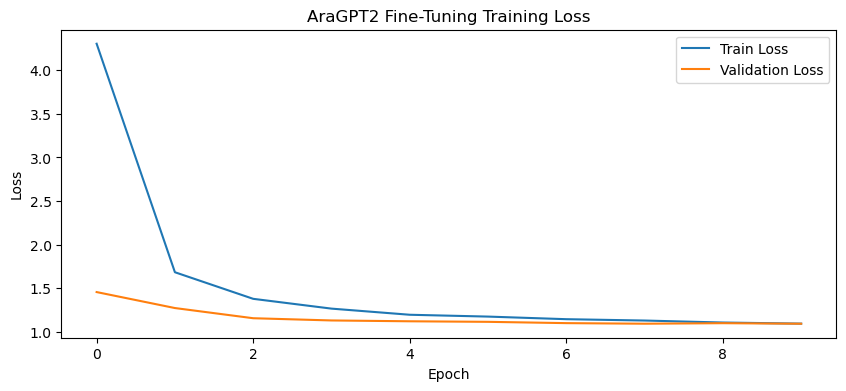

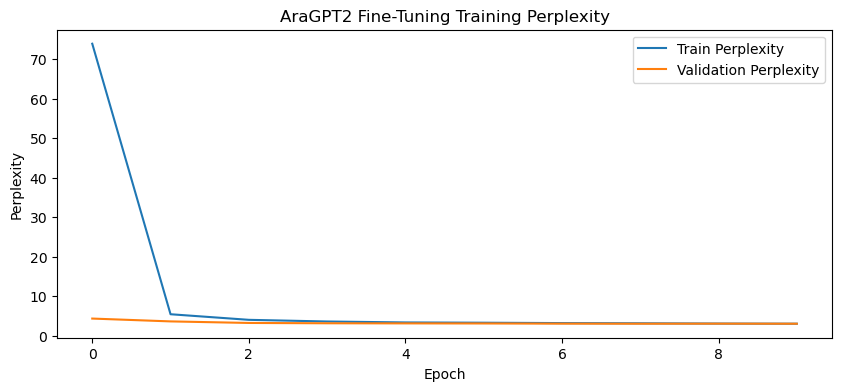

In [11]:
# --------------------------
# 7) Plot Training History
# --------------------------
try:
    plt.figure(figsize=(10, 4))
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Validation Loss')
    plt.title("AraGPT2 Fine-Tuning Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(hist['train_perplexity'], label='Train Perplexity')
    plt.plot(hist['val_perplexity'], label='Validation Perplexity')
    plt.title("AraGPT2 Fine-Tuning Training Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error while plotting training history: {e}")

In [12]:
# -------------
# 3) Diffusion Model
# -------------
max_length = 128
max_bayt_len = 128  # for Diffusion, must match
encoding_dim = 8    # each token vector dimension# Initialize and load the Diffusion Model
# Initialize and load the Diffusion Model
print("Initializing Diffusion Model...")
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}
input_shape = (max_bayt_len, encoding_dim)
diffusion_model = create_diffusion_model_pytorch(input_shape, diffusion_model_params).to('cuda' if torch.cuda.is_available() else 'cpu')
print("Diffusion Model initialized.")

# Optionally, load a pre-trained diffusion model
diffusion_checkpoint_path = os.path.join(diffusion_output_dir, "diffusion_model_final.pt")
if os.path.exists(diffusion_checkpoint_path):
    diffusion_model.load_state_dict(torch.load(diffusion_checkpoint_path, map_location=device))
    print(f"Loaded pre-trained Diffusion Model from '{diffusion_checkpoint_path}'")
else:
    print("No pre-trained Diffusion Model found. Proceeding with randomly initialized model.")


Initializing Diffusion Model...
Diffusion Model initialized.
No pre-trained Diffusion Model found. Proceeding with randomly initialized model.


In [13]:
# ---------------
# 4) Train Diffusion Model (Optional)
# ---------------
print("Training Diffusion Model...")
try:
    trained_combined_model, training_history = train_diffusion_with_gpt2_decoder(
        df_classical=train_subset,
        diffusion_model=diffusion_model,
        tokenizer=transformer_tokenizer,
        preprocessor=preprocessor,
        max_length=128,
        max_bayt_len=128,
        encoding_dim=8,
        epochs=10,
        batch_size=8,
        output_dir=diffusion_output_dir,
        learning_rate=1e-4,
        patience=3,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print("Diffusion Model training complete.")
except Exception as e:
    print(f"Error during Diffusion Model training: {e}")
    

Training Diffusion Model...
Projection layer added: 8 -> 768


Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch 1/10 | Train Loss: 3.8678 | Val Loss: 1.8180
Saved best model to '../models/diffusion/diffusion_model_epoch_1.pt'


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 2/10 | Train Loss: 1.8261 | Val Loss: 1.6417
Saved best model to '../models/diffusion/diffusion_model_epoch_2.pt'


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 3/10 | Train Loss: 1.6563 | Val Loss: 1.5644
Saved best model to '../models/diffusion/diffusion_model_epoch_3.pt'


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 4/10 | Train Loss: 1.5189 | Val Loss: 1.4723
Saved best model to '../models/diffusion/diffusion_model_epoch_4.pt'


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch 5/10 | Train Loss: 1.3506 | Val Loss: 1.4345
Saved best model to '../models/diffusion/diffusion_model_epoch_5.pt'


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Epoch 6/10 | Train Loss: 1.2613 | Val Loss: 1.2452
Saved best model to '../models/diffusion/diffusion_model_epoch_6.pt'


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 7/10 | Train Loss: 1.2231 | Val Loss: 1.2494
No improvement in validation loss for 1 epoch(s).


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 8/10 | Train Loss: 1.1585 | Val Loss: 1.2337
Saved best model to '../models/diffusion/diffusion_model_epoch_8.pt'


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 9/10 | Train Loss: 1.1072 | Val Loss: 1.2368
No improvement in validation loss for 1 epoch(s).


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.27it/s]

Epoch 10/10 | Train Loss: 1.0863 | Val Loss: 1.3239
No improvement in validation loss for 2 epoch(s).
Training complete.
Diffusion Model training complete.


In [14]:
# Save the final combined model
final_model_path = os.path.join(diffusion_output_dir, 'final_diffusion_model_with_decoder.pt')
torch.save(trained_combined_model.state_dict(), final_model_path)
print(f"Final combined model saved to '{final_model_path}'")

Final combined model saved to '../models/diffusion/final_diffusion_model_with_decoder.pt'


In [15]:
# ------------------
# 5) Provide a Modern Prompt
# ------------------
modern_prompt = "يا جمال الزمان ويا نور الأمل"

# ------------------
# 6) Generate Final Poem via ThePoet -> AraGPT2 -> Diffusion
# ------------------
print("Generating final classical poem by chaining ThePoet -> AraGPT2 -> Diffusion...")
try:
    final_poem = generate_classical_poem_with_thepoet(
        modern_prompt=modern_prompt,
        poet_pipeline=poet_pipeline,
        transformer_model=trained_transformer,
        transformer_tokenizer=transformer_tokenizer,
        diffusion_model=trained_combined_model,  # Pass the trained combined model here
        diffusion_tokenizer=transformer_tokenizer,  # Assuming same tokenizer; adjust if different
        max_length=128,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print("\n==== Final Chained Poem ====")
    print(final_poem)
    print("================================")
except Exception as e:
    print(f"Error during poem generation: {e}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generating final classical poem by chaining ThePoet -> AraGPT2 -> Diffusion...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Generated rough poems from ThePoet:
1: يا جمال الزمان ويا نور الأمل. وإني على العهد القديم - من بعد ما قد مضى عهد الصبا. ألا يا خير الورى في كل عام - وفي كل يوم عيد أضحى عيدا. فإن لم يكن لي منه نصيب
Replaced hyphen with three spaces: وإني على العهد القديم     من بعد ما قد مضى عهد الصبا
Added missing period to verse: وإني على العهد القديم     من بعد ما قد مضى عهد الصبا.
Replaced hyphen with three spaces: ألا يا خير الورى في كل عام     وفي كل يوم عيد أضحى عيدا
Added missing period to verse: ألا يا خير الورى في كل عام     وفي كل يوم عيد أضحى عيدا.
Verse does not have two halves. Fixed verse: فإن لم يكن   لي منه نصيب
Attempt 1: Generated poems do not match the required format. Regenerating...

Generated rough poems from ThePoet:
1: فإن لم يكن لي منه نصيب - وإن لم يكن لك فيه نصيب. وإني لأرجو من الله أن يرحمني - على رغم ما قد كان مني مورد. ألا يا نفس إن كنت لا تعلمي - بأن الذي
Replaced hyphen with three spaces: فإن لم يكن لي منه نصيب     وإن لم يكن لك فيه نصيب
Added missing period to verse:

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: يا جَمالُ الزَّمانِ وَيا نورَ الأَمَلِ
Diacritized Verse re-split into halves: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِ
Classical Draft from AraGPT2: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِمن
Classical Draft after filtering non-Arabic characters: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِمن
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

Processing Verse 2: وإني على العهد القديم من بعد ما قد مضى عهد الصبا
Verse split into halves: وإني على العهد القديم من   بعد ما قد مضى عهد الصبا


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: وَإِنّي عَلَى العَهْدِ القَديمِ مِنْ بَعْدِ ما قَدْ مَضَى عَهْدُ الصِّبا
Diacritized Verse re-split into halves: وَإِنّي عَلَى العَهْدِ القَديمِ مِنْ   بَعْدِ ما قَدْ مَضَى عَهْدُ الصِّبا
Classical Draft from AraGPT2: وَإِنّي عَلَى العَهْدِ القَديمِ مِنْ   بَعْدِ ما قَدْ مَضَى عَهْدُ الصِّبامن
Classical Draft after filtering non-Arabic characters: وَإِنّي عَلَى العَهْدِ القَديمِ مِنْ   بَعْدِ ما قَدْ مَضَى عَهْدُ الصِّبامن
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

Processing Verse 3: ألا يا خير الورى في كل عام وفي كل يوم عيد أضحى عيدا
Verse split into halves: ألا يا خير الورى في كل   عام وفي كل يوم عيد أضحى عيدا


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: أَلّا يا خَيْرَ الوَرَى في كُلِّ عامٍ وَفي كُلِّ يَوْمٍ عيدِ أَضْحَى عيدًا
Diacritized Verse re-split into halves: أَلّا يا خَيْرَ الوَرَى في كُلِّ   عامٍ وَفي كُلِّ يَوْمٍ عيدِ أَضْحَى عيدًا
Classical Draft from AraGPT2: أَلّا يا خَيْرَ الوَرَى في كُلِّ   عامٍ وَفي كُلِّ يَوْمٍ عيدِ أَضْحَى عيدًا ء
Classical Draft after filtering non-Arabic characters: أَلّا يا خَيْرَ الوَرَى في كُلِّ   عامٍ وَفي كُلِّ يَوْمٍ عيدِ أَضْحَى عيدًا ء
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

Processing Verse 4: فإن لم يكن لي منه نصيب
Verse split into halves: فإن لم يكن   لي منه نصيب


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: فَإِنْ لَمْ يَكُنْ لي مِنْهُ نَصيبٌ
Diacritized Verse re-split into halves: فَإِنْ لَمْ يَكُنْ   لي مِنْهُ نَصيبٌ
Classical Draft from AraGPT2: فَإِنْ لَمْ يَكُنْ   لي مِنْهُ نَصيبٌن
Classical Draft after filtering non-Arabic characters: فَإِنْ لَمْ يَكُنْ   لي مِنْهُ نَصيبٌن
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

Processing Verse 5: فإن لم يكن لي منه نصيب وإن لم يكن لك فيه نصيب
Verse split into halves: فإن لم يكن لي منه نصيب   وإن لم يكن لك فيه نصيب


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: فَإِنْ لَمْ يَكُنْ لي مِنْهُ نَصيبٌ وَإِنْ لَمْ يَكُنْ لَكَ فيهِ نَصيبٌ
Diacritized Verse re-split into halves: فَإِنْ لَمْ يَكُنْ لي مِنْهُ نَصيبٌ   وَإِنْ لَمْ يَكُنْ لَكَ فيهِ نَصيبٌ
Classical Draft from AraGPT2: فَإِنْ لَمْ يَكُنْ لي مِنْهُ نَصيبٌ   وَإِنْ لَمْ يَكُنْ لَكَ فيهِ نَصيبٌمن
Classical Draft after filtering non-Arabic characters: فَإِنْ لَمْ يَكُنْ لي مِنْهُ نَصيبٌ   وَإِنْ لَمْ يَكُنْ لَكَ فيهِ نَصيبٌمن
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

Processing Verse 6: وإني لأرجو من الله أن يرحمني على رغم ما قد كان مني مورد
Verse split into halves: وإني لأرجو من الله أن يرحمني   على رغم ما قد كان مني مورد


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: وَإِنّي لَأَرْجو مِنْ اللَّهِ أَنْ يَرْحَمْني عَلَى رَغْمَ ما قَدْ كانَ مِنّي مَوْرِدٌ
Diacritized Verse re-split into halves: وَإِنّي لَأَرْجو مِنْ اللَّهِ أَنْ يَرْحَمْني   عَلَى رَغْمَ ما قَدْ كانَ مِنّي مَوْرِدٌ
Classical Draft from AraGPT2: وَإِنّي لَأَرْجو مِنْ اللَّهِ أَنْ يَرْحَمْني   عَلَى رَغْمَ ما قَدْ كانَ مِنّي مَوْرِدٌمن
Classical Draft after filtering non-Arabic characters: وَإِنّي لَأَرْجو مِنْ اللَّهِ أَنْ يَرْحَمْني   عَلَى رَغْمَ ما قَدْ كانَ مِنّي مَوْرِدٌمن
Passing verse through Diffusion Model for further refinement...
Final Verse after Diffusion Refinement: ننننننننننننننننننن

==== Final Chained Poem ====
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن

==== Final Chained Poem ====
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن
ننننننننننننننننننن


In [ ]:
# ------------------
# 4) Provide a Modern Prompt
# ------------------
modern_prompt = "يا جمال الزمان ويا نور الأمل"

# ------------------
# 5) Generate Final Poem via ThePoet -> AraGPT2
# ------------------
print("Generating final classical poem by chaining ThePoet -> AraGPT2...")
try:
    final_poem = generate_classical_poem_with_thepoet(
        modern_prompt=modern_prompt,
        poet_pipeline=poet_pipeline,
        transformer_model=trained_transformer,
        transformer_tokenizer=transformer_tokenizer,
        # diffusion_model=diffusion_model,  # Uncomment if using diffusion
        max_length=128,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print("\n==== Final Chained Poem ====")
    print(final_poem)
    print("================================")
except Exception as e:
    print(f"Error during poem generation: {e}")


In [11]:
# ------------------
# 4) Provide a Modern Prompt
# ------------------
modern_prompt = "يا جمال الزمان ويا نور الأمل"

# ------------------
# 5) Generate Final Poem via ThePoet -> AraGPT2
# ------------------
print("Generating final classical poem by chaining ThePoet -> AraGPT2...")
try:
    final_poem = generate_classical_poem_with_thepoet(
        modern_prompt=modern_prompt,
        poet_pipeline=poet_pipeline,
        transformer_model=trained_transformer,
        transformer_tokenizer=transformer_tokenizer,
        # diffusion_model=diffusion_model,  # Uncomment if using diffusion
        max_length=128,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    print("\n==== Final Chained Poem ====")
    print(final_poem)
    print("================================")
except Exception as e:
    print(f"Error during poem generation: {e}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Generating final classical poem by chaining ThePoet -> AraGPT2...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Generated rough poems from ThePoet:
1: يا جمال الزمان ويا نور الأمل. أحسنت يا بدر الدجى - ما أنت إلا البدر المنير. وإذا لم يكن في الكون نجم - فذاك هو النور المبين. فإن كنت من أهل الورى - فما
Replaced hyphen with three spaces: أحسنت يا بدر الدجى     ما أنت إلا البدر المنير
Added missing period to verse: أحسنت يا بدر الدجى     ما أنت إلا البدر المنير.
Replaced hyphen with three spaces: وإذا لم يكن في الكون نجم     فذاك هو النور المبين
Added missing period to verse: وإذا لم يكن في الكون نجم     فذاك هو النور المبين.
Replaced hyphen with three spaces: فإن كنت من أهل الورى     فما
Added missing period to verse: فإن كنت من أهل الورى     فما.
Attempt 1: Generated poems do not match the required format. Regenerating...

Generated rough poems from ThePoet:
1: فإن كنت من أهل الورى - فما لك في الناس من نظير. وإذا أنت لم تسألي عن أمر - فلا تجزعن إلى ما شئت من فاعل. ولا تلمني على الزمان الذي مضى - ولا تعذلني
Replaced hyphen with three spaces: فإن كنت من أهل الورى     فما لك في الناس من نظير
Added 

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: يا جَمالُ الزَّمانِ وَيا نورَ الأَمَلِ
Diacritized Verse re-split into halves: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِ
Classical Draft from AraGPT2: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِ��ن��� ���ه���������������
Final Verse after AraGPT2 Refinement: يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِن ه

Processing Verse 2: أحسنت يا بدر الدجى ما أنت إلا البدر المنير
Verse split into halves: أحسنت يا بدر الدجى   ما أنت إلا البدر المنير


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: أَحْسَنتْ يا بَدْرُ الدُّجَى ما أَنْتَ إِلّا البَدْرِ المُنيرِ
Diacritized Verse re-split into halves: أَحْسَنتْ يا بَدْرُ الدُّجَى   ما أَنْتَ إِلّا البَدْرِ المُنيرِ
Classical Draft from AraGPT2: أَحْسَنتْ يا بَدْرُ الدُّجَى   ما أَنْتَ إِلّا البَدْرِ المُنيرِ�ن���ه��ر���
Final Verse after AraGPT2 Refinement: أَحْسَنتْ يا بَدْرُ الدُّجَى   ما أَنْتَ إِلّا البَدْرِ المُنيرِنهر

Processing Verse 3: وإذا لم يكن في الكون نجم فذاك هو النور المبين
Verse split into halves: وإذا لم يكن في الكون   نجم فذاك هو النور المبين


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: وَإِذا لَمْ يَكُنْ في الكَوْنِ نَجْمُ فَذاكَ هوَ النّورُ المُبينُ
Diacritized Verse re-split into halves: وَإِذا لَمْ يَكُنْ في الكَوْنِ   نَجْمُ فَذاكَ هوَ النّورُ المُبينُ
Classical Draft from AraGPT2: وَإِذا لَمْ يَكُنْ في الكَوْنِ   نَجْمُ فَذاكَ هوَ النّورُ المُبينُ��ن��ه��
Final Verse after AraGPT2 Refinement: وَإِذا لَمْ يَكُنْ في الكَوْنِ   نَجْمُ فَذاكَ هوَ النّورُ المُبينُنه

Processing Verse 4: فإن كنت من أهل الورى فما
Verse split into halves: فإن كنت من   أهل الورى فما


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى فَما
Diacritized Verse re-split into halves: فَإِنْ كُنْتْ مِنْ   أَهْلِ الوَرَى فَما
Classical Draft from AraGPT2: فَإِنْ كُنْتْ مِنْ   أَهْلِ الوَرَى فَما�ن�����ه���� �����
Final Verse after AraGPT2 Refinement: فَإِنْ كُنْتْ مِنْ   أَهْلِ الوَرَى فَمانه 

Processing Verse 5: فإن كنت من أهل الورى فما لك في الناس من نظير
Verse split into halves: فإن كنت من أهل الورى   فما لك في الناس من نظير


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى فَما لَكَ في النّاسِ مِنْ نَظيرِ
Diacritized Verse re-split into halves: فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى   فَما لَكَ في النّاسِ مِنْ نَظيرِ
Classical Draft from AraGPT2: فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى   فَما لَكَ في النّاسِ مِنْ نَظيرِ�ن���ه��
Final Verse after AraGPT2 Refinement: فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى   فَما لَكَ في النّاسِ مِنْ نَظيرِنه

Processing Verse 6: وإذا أنت لم تسألي عن أمر فلا تجزعن إلى ما شئت من فاعل
Verse split into halves: وإذا أنت لم تسألي عن أمر   فلا تجزعن إلى ما شئت من فاعل


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Diacritized Verse: وَإِذا أَنْتَ لَمْ تَسْأَلْي عَنْ أَمْرٍ فَلا تجزعنْ إِلَى ما شِئتْ مِنْ فاعِلٍ
Diacritized Verse re-split into halves: وَإِذا أَنْتَ لَمْ تَسْأَلْي عَنْ أَمْرٍ   فَلا تجزعنْ إِلَى ما شِئتْ مِنْ فاعِلٍ
Classical Draft from AraGPT2: وَإِذا أَنْتَ لَمْ تَسْأَلْي عَنْ أَمْرٍ   فَلا تجزعنْ إِلَى ما شِئتْ مِنْ فاعِلٍ��ن�
Final Verse after AraGPT2 Refinement: وَإِذا أَنْتَ لَمْ تَسْأَلْي عَنْ أَمْرٍ   فَلا تجزعنْ إِلَى ما شِئتْ مِنْ فاعِلٍن

==== Final Chained Poem ====
يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِن ه
أَحْسَنتْ يا بَدْرُ الدُّجَى   ما أَنْتَ إِلّا البَدْرِ المُنيرِنهر
وَإِذا لَمْ يَكُنْ في الكَوْنِ   نَجْمُ فَذاكَ هوَ النّورُ المُبينُنه
فَإِنْ كُنْتْ مِنْ   أَهْلِ الوَرَى فَمانه 
فَإِنْ كُنْتْ مِنْ أَهْلِ الوَرَى   فَما لَكَ في النّاسِ مِنْ نَظيرِنه
وَإِذا أَنْتَ لَمْ تَسْأَلْي عَنْ أَمْرٍ   فَلا تجزعنْ إِلَى ما شِئتْ مِنْ فاعِلٍن

==== Final Chained Poem ====
يا جَمالُ الزَّمانِ   وَيا نورَ الأَمَلِن ه
أَحْسَنتْ يا بَدْرُ الدُّجَى   ما أَنْتَ إِلّا البَدْرِ ال